<a href="https://colab.research.google.com/github/AdanMDG/Sistema_de_Recomendacion/blob/main/SistemaDeRecomendacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga y procesamiento del conjunto de datos

In [ ]:
#Importar las librerias necesarias
from google.colab import drive # Soporte para cargar dataset de Drive
import pandas as pd
import re
import nltk
!pip install unidecode
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
!pip install seaborn==0.12.2
import seaborn as sns
from IPython.display import display, HTML

#Acceder al Dataset
drive.mount('/content/drive')
ruta_excel = "../content/drive/MyDrive/Facultad/Tandil/Optativas/Sistemas de Recomendacion/Práctica/TP Final/Enseñanza de la Trigonometría (respuestas).xlsx"
df = pd.read_excel(ruta_excel)

#Borrar columnas donde se pregunta por la carga de otro problema
df = df.drop([df.columns[15], df.columns[22], df.columns[29], df.columns[36], df.columns[43]], axis=1)

#Eliminar las entradas de profesroes que no enseñaron trigonometría
df = df[df.iloc[:, 3] != "No"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Procesamiento de campos
En esta etapa se procesan los campos necesarios para estandarizar los conjuntos de datos. Los campos son "si" o "no" se convierten a valores booleanos y se extrae el valor numerico de los campos referidos a los años de experiencia o en el que se dio un problema

In [ ]:
#Convertir entradas de texto por si o por no a sus equivalentes booleanos.
df.iloc[:, 3] = df.iloc[:, 3].map({'Si': True, 'No': False, 'si': True, 'no': False, 'SI': True, 'NO': False})

#Convertir entradas de texto a campos numericos.
def extraer_numeros(texto):
    numeros = re.findall(r'\b[1-6]\b', str(texto))
    return ' '.join(numeros)  # Unimos los números extraídos en una sola cadena

df.iloc[:, 4] = df.iloc[:, 4].apply(extraer_numeros)


Tokenizamos los campos de texto eliminando las stopwords

Por ahora no seleccionamos palabras mas representativas y nos quedamos con todos los tokens. Si hace falta lo hacemos para mejorar resultados

In [ ]:
# Función para convertir a mayúsculas y remover acentos
def convertir_mayusculas_sin_acentos(texto):
    if pd.isna(texto):
        return texto
    texto_mayusculas = texto.upper()
    return unidecode(texto_mayusculas)

# Seleccionamos las columnas a procesar
columnas_texto = ["¿Cuál es la modalidad/especialidad de la escuela donde más frecuentemente enseña trigonometría?", "Orientación ", "Describa los temas de trigonometría que enseña o ha enseñado, indicando el año escolar en cada caso.", "¿Cuáles son los conocimientos fundamentales tanto de trigonometría como de otras áreas que se necesitan para resolver el problema que propuso? ","Conocimientos previos para resolver el problema."]

stop_words = set(stopwords.words('spanish'))

# Itera sobre las columnas de texto y remueve las stopwords
for columna in columnas_texto:
    # Asegurarse de que los valores no sean NaN
    df[columna] = df[columna].fillna('')

    # Tokeniza y elimina las stopwords
    df[columna] = df[columna].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words]))
    df[columna] = df[columna].apply(convertir_mayusculas_sin_acentos)

# Etapa offline

En esta etapa se definirán las medidas de igualdad para la comparación de perfiles de profesor y se formarán clusters en base a estos perfiles.

## Medidas de igualdad entre profesores

In [ ]:
def comparar_igualdad(x, y):
    return 1 if x == y else 0

def comparar_provincia(x, y):
    if pd.isna(x) or pd.isna(y):
        return 0
    return comparar_igualdad(x, y)

# Funcion sin uso, fue definida antes de obtener planilla con respuestas actualizadas
def comparar_experiencia(x, y):
    if pd.isna(x) or pd.isna(y):
        return 0
    x = int(x)  # Asegurarse de que x sea un entero
    y = int(y)  # Asegurarse de que y sea un entero
    return 1 - abs(x - y) / 6

def similitud_jaccard(x, y):
    tokens_x = set(word_tokenize(x))
    tokens_y = set(word_tokenize(y))
    return len(tokens_x & tokens_y) / len(tokens_x | tokens_y)

Asignamos pesos a cada atributo del profesor dandole un valor mayor a los que consideramos mas relevantes para hallar sus similitudes


In [ ]:
PESO_PAIS = 0.1
PESO_PROVINCIA = 0.05
PESO_EXPERIENCIA = 0.2125
PESO_MODALIDAD = 0.2125
PESO_ORIENTACION = 0.2125
PESO_TEMAS = 0.2125

def similitud_usuarios(usuario1, usuario2):
    pais_sim = comparar_igualdad(usuario1['¿En qué país se desempeña como profesor de matemática?'], usuario2['¿En qué país se desempeña como profesor de matemática?'])
    provincia_sim = comparar_provincia(usuario1['Si seleccionó Argentina ¿En qué provincia se desempeña como profesor/a de matemática?'], usuario2['Si seleccionó Argentina ¿En qué provincia se desempeña como profesor/a de matemática?'])
    experiencia_sim = similitud_jaccard(usuario1['Curso en el que considera tener mayor experiencia enseñando trigonometría (puede seleccionar más de uno).'], usuario2['Curso en el que considera tener mayor experiencia enseñando trigonometría (puede seleccionar más de uno).'])
    modalidad_sim = comparar_igualdad(usuario1['¿Cuál es la modalidad/especialidad de la escuela donde más frecuentemente enseña trigonometría?'], usuario2['¿Cuál es la modalidad/especialidad de la escuela donde más frecuentemente enseña trigonometría?'])
    orientacion_sim = comparar_igualdad(usuario1['Orientación '], usuario2['Orientación '])
    temas_sim = similitud_jaccard(usuario1['Describa los temas de trigonometría que enseña o ha enseñado, indicando el año escolar en cada caso.'], usuario2['Describa los temas de trigonometría que enseña o ha enseñado, indicando el año escolar en cada caso.'])

    # Suma ponderada
    total_sim = PESO_PAIS*pais_sim + PESO_PROVINCIA*provincia_sim + PESO_EXPERIENCIA*experiencia_sim + PESO_MODALIDAD*modalidad_sim + PESO_ORIENTACION*orientacion_sim + PESO_TEMAS*temas_sim
    return total_sim

## Comparacion y visualizacion de resultados

Crear y graficar matriz de similitud

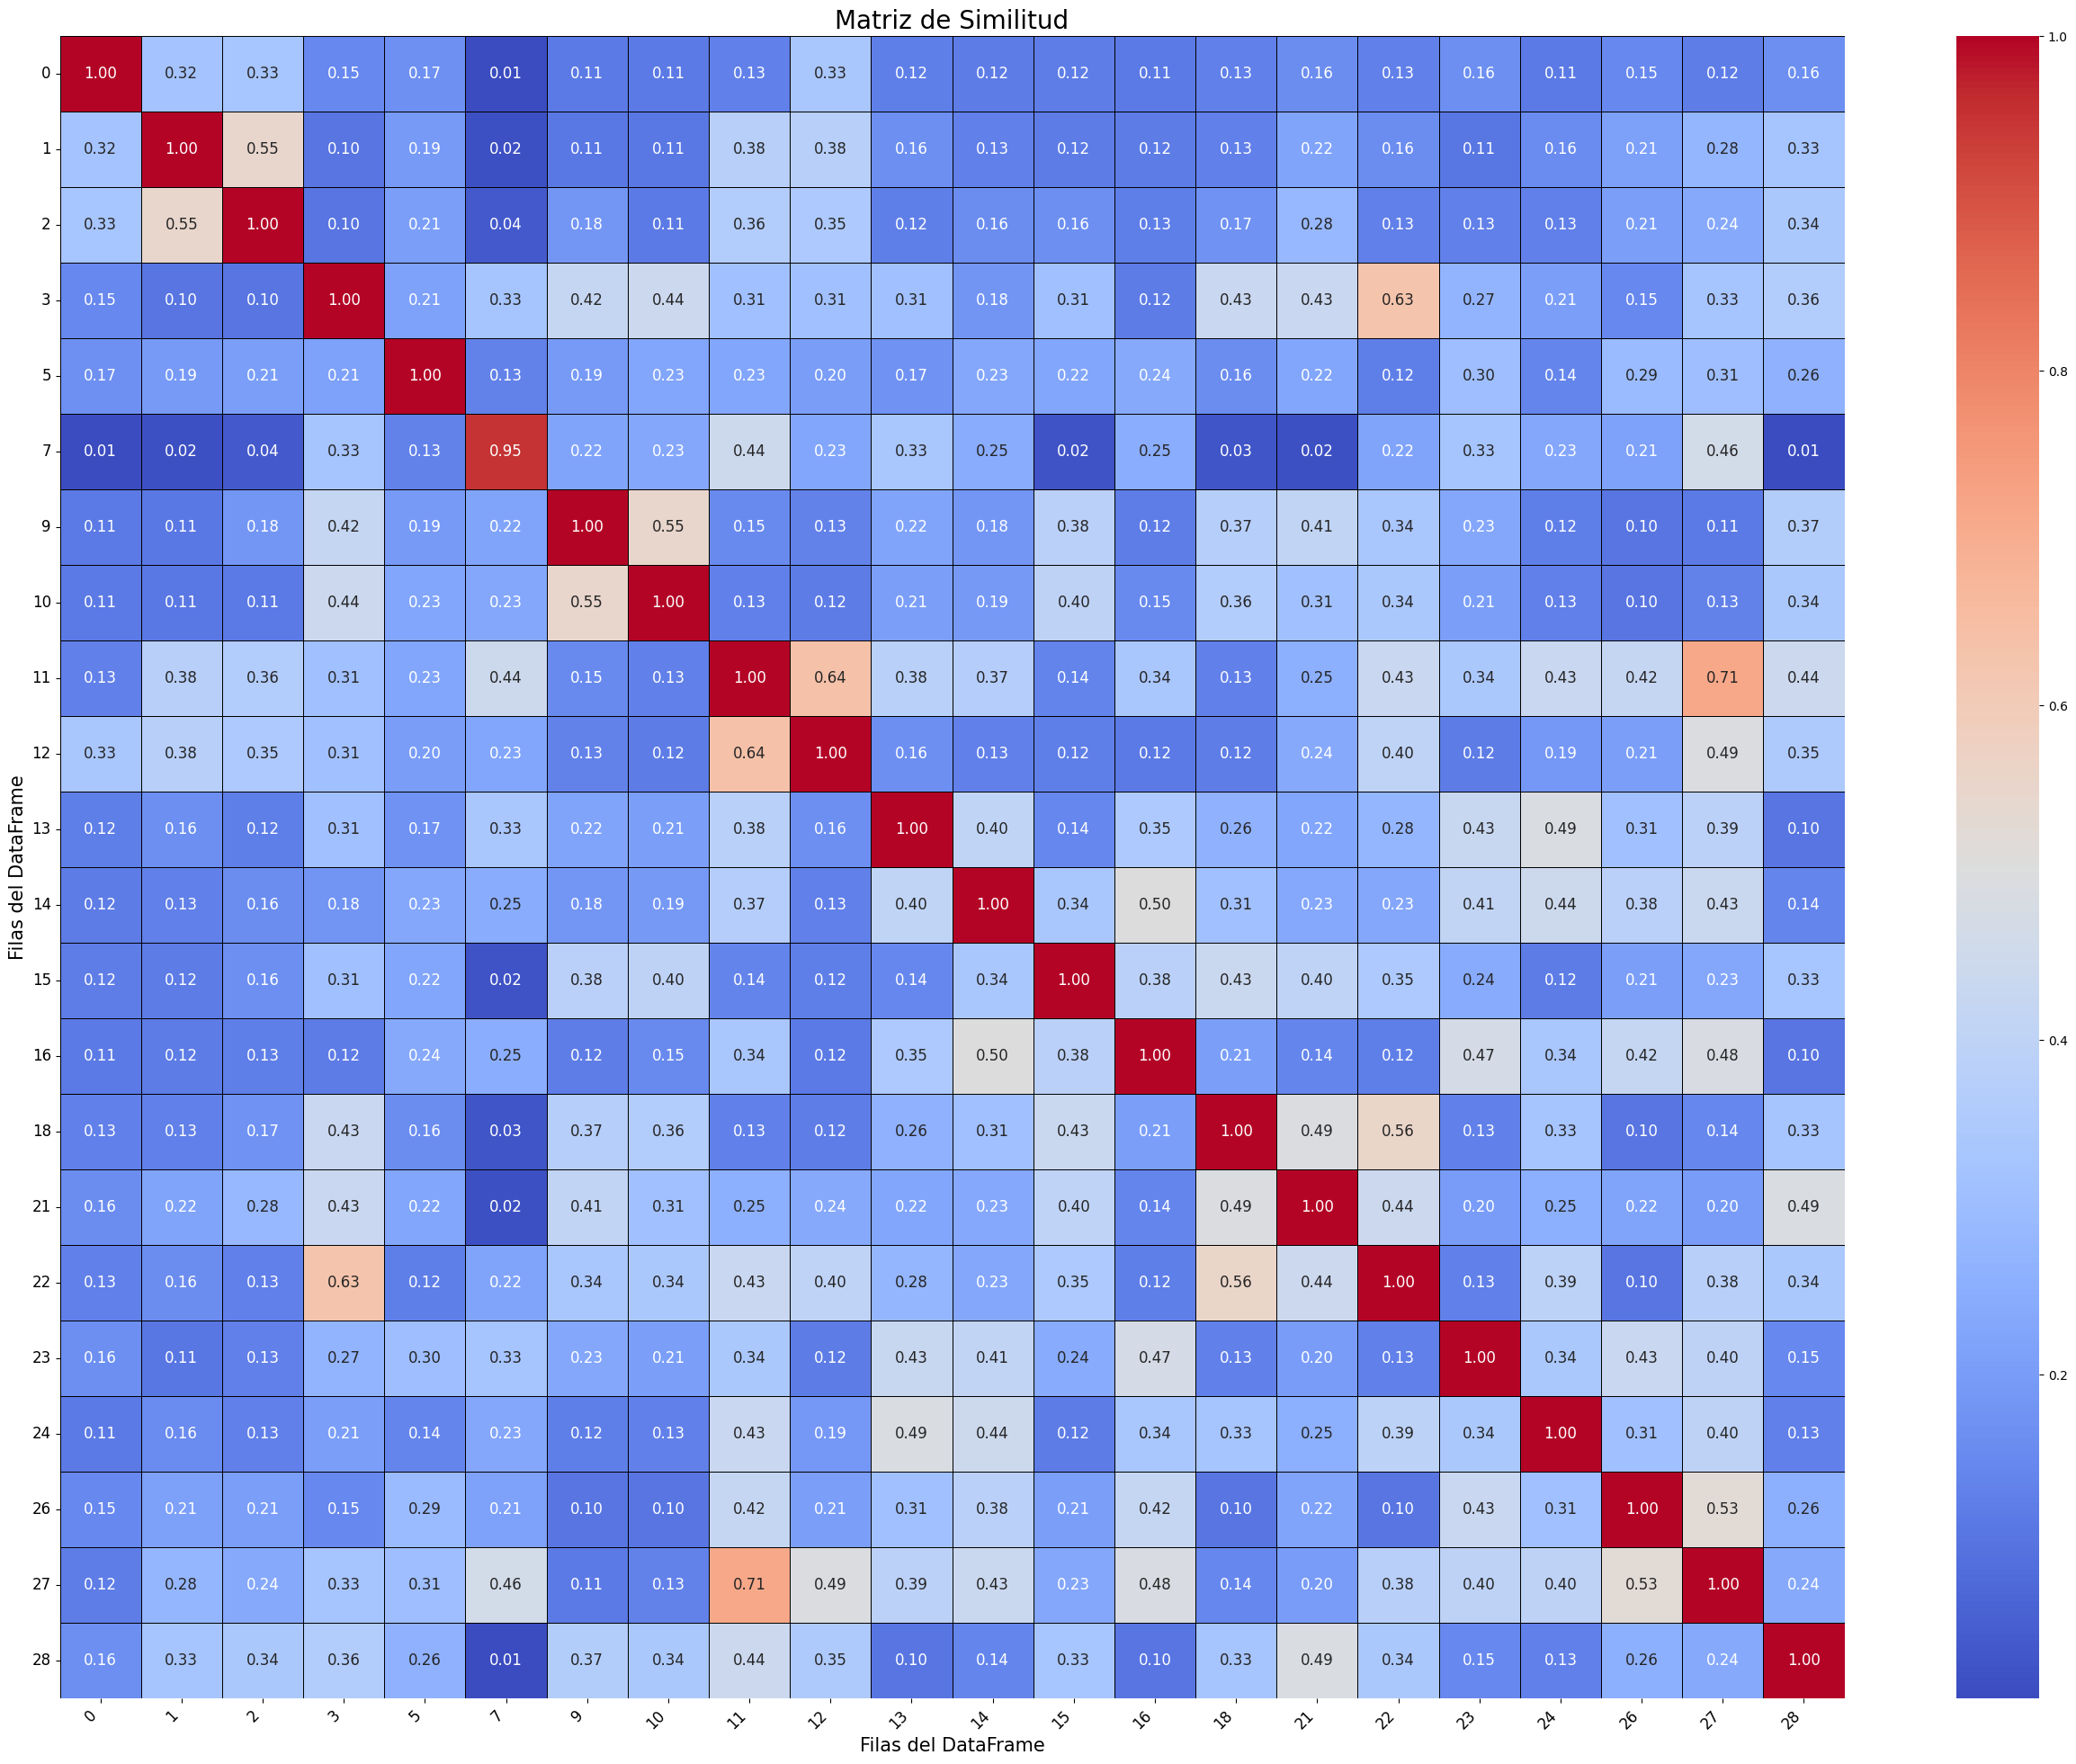

In [ ]:
# Crear una matriz de similitud
n = len(df)
matriz_similitud = np.zeros((n, n))

for i in range(n):
    for j in range(n):
      matriz_similitud[i, j] = similitud_usuarios(df.iloc[i], df.iloc[j])


# Crear la figura y el eje, ajustando el tamaño de la figura
plt.figure(figsize=(32, 24))  # Aumenta el tamaño según sea necesario

# Crear el heatmap
sns.heatmap(matriz_similitud, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12},
            xticklabels=df.index, yticklabels=df.index, cbar=True, linewidths=0.5, linecolor='black')

# Personalizar títulos y etiquetas
plt.title('Matriz de Similitud', fontsize=20)
plt.xlabel('Filas del DataFrame', fontsize=15)
plt.ylabel('Filas del DataFrame', fontsize=15)

# Asegurarse de que los ticks (etiquetas) no se superpongan
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Mostrar el gráfico en Colab
plt.show()

Convertir a matriz de distancias y graficarla

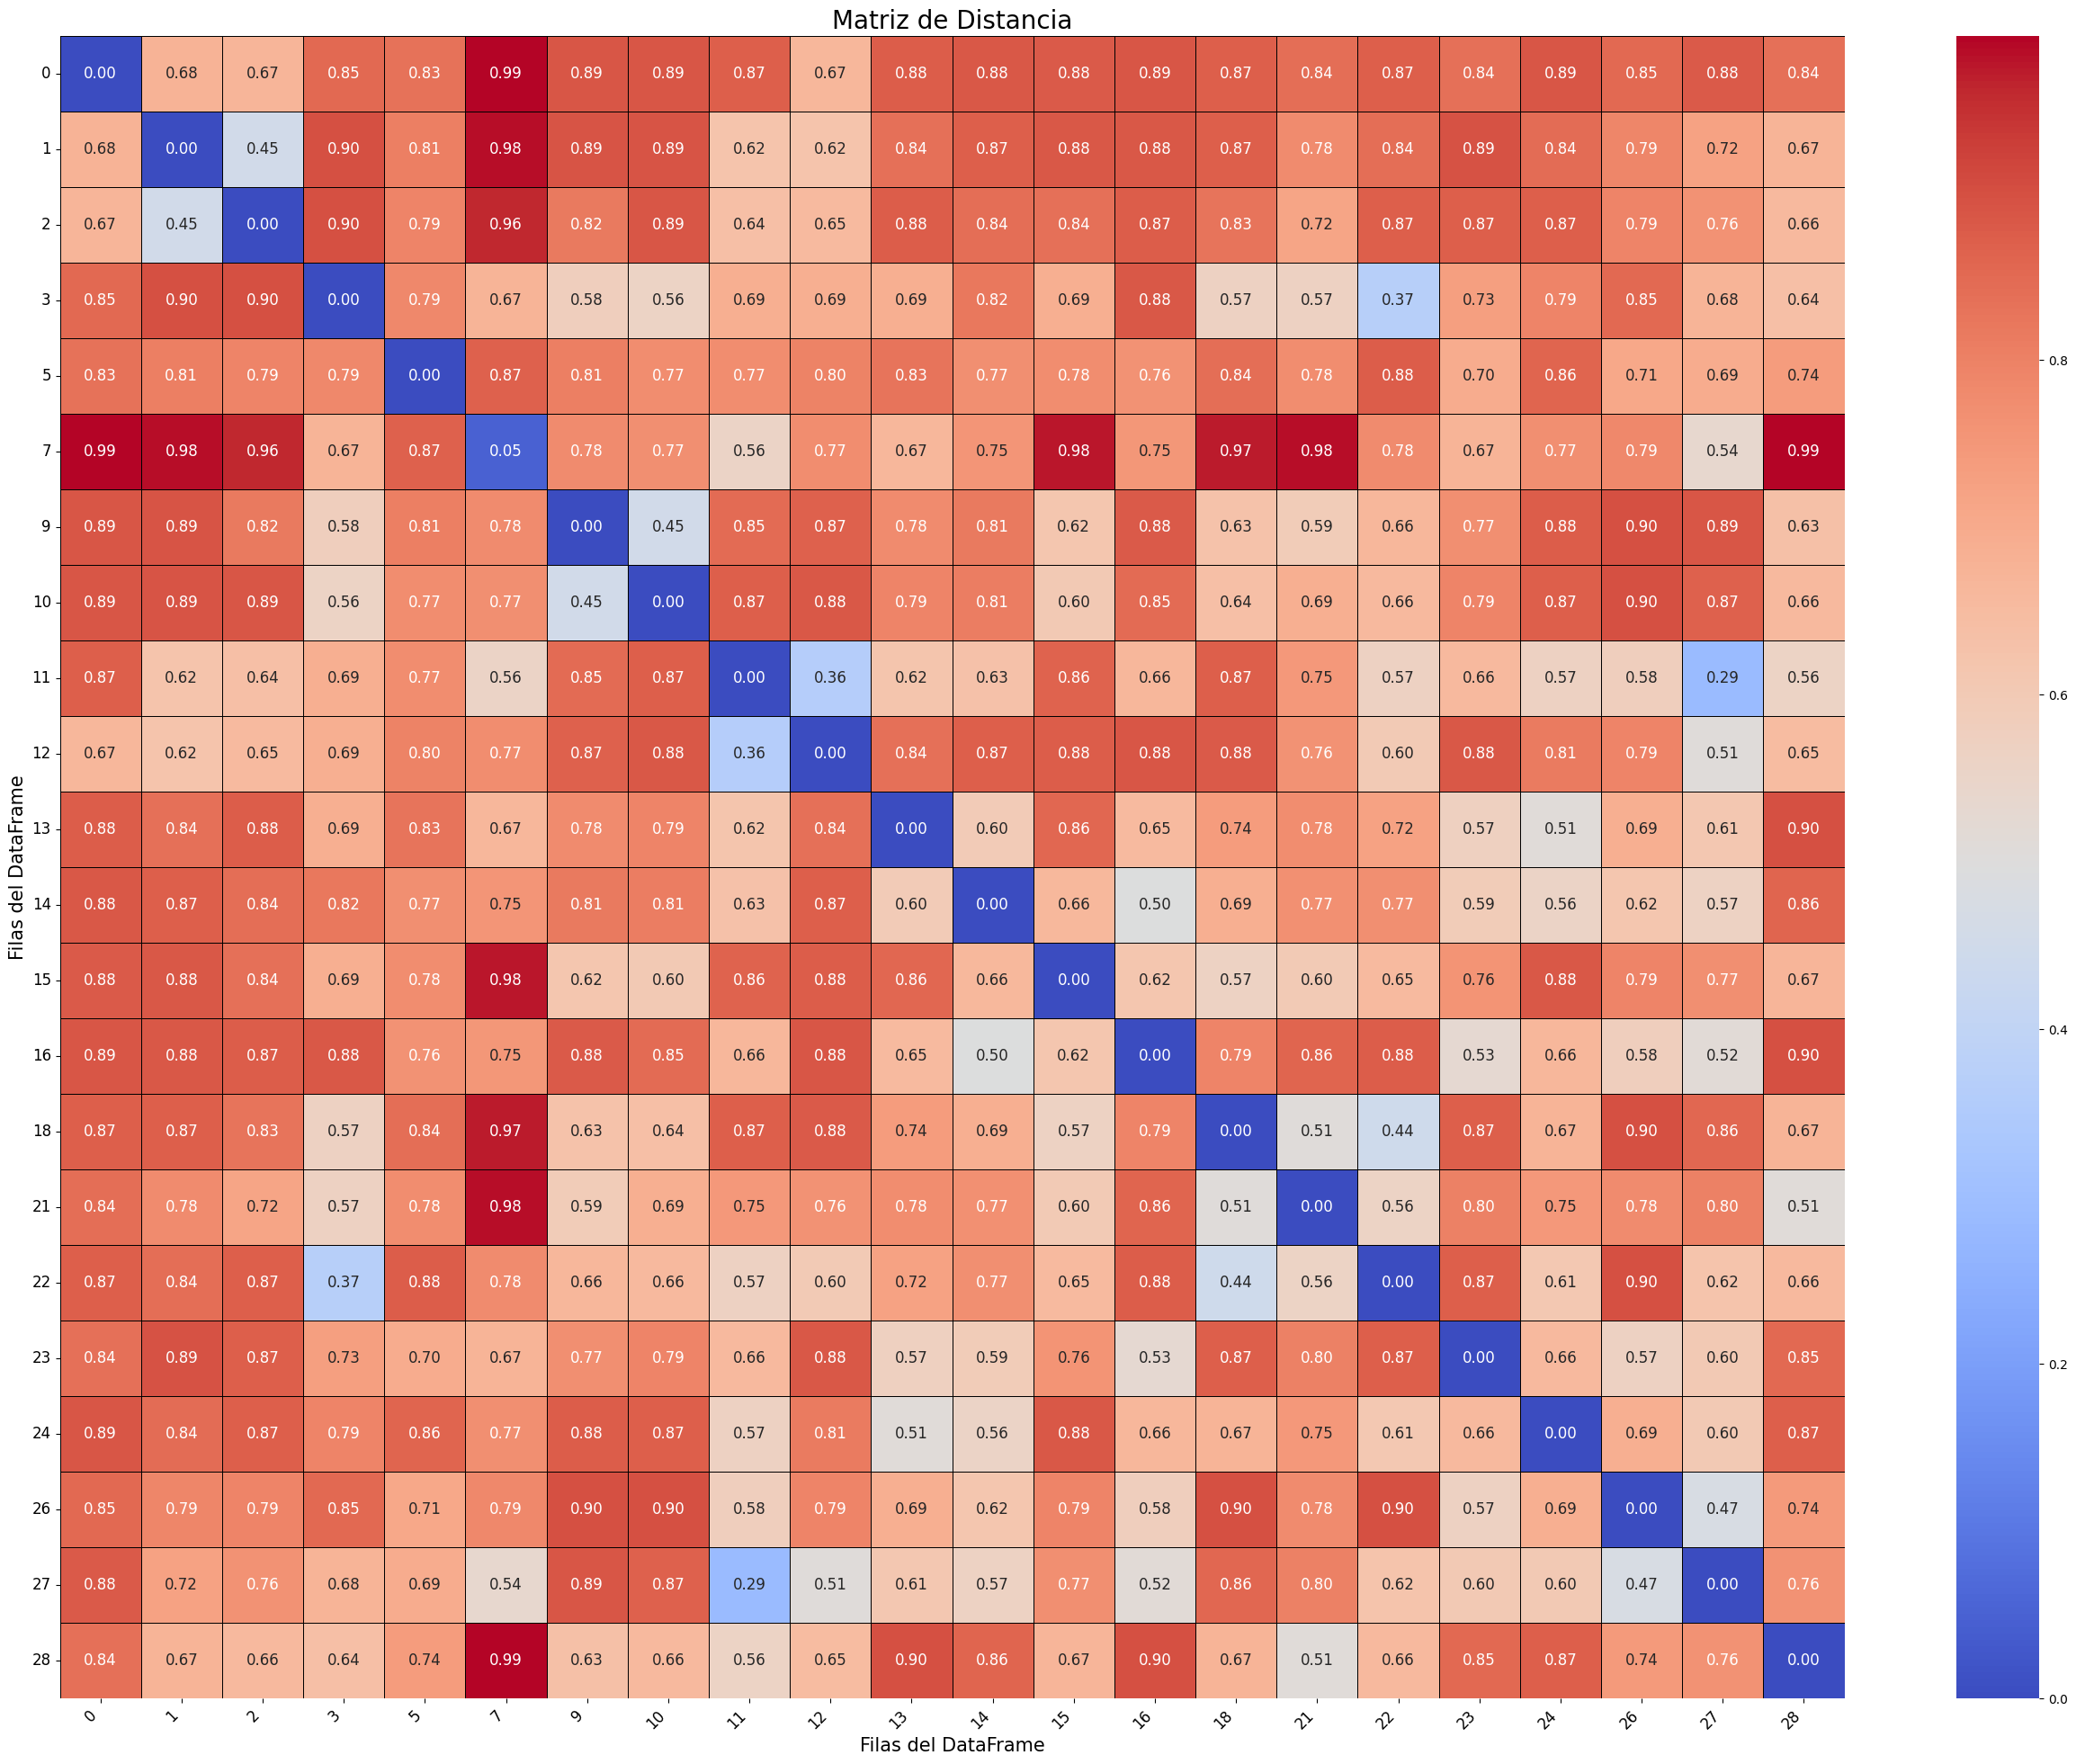

In [ ]:
# Convertir la matriz de similitud a una matriz de distancia
matriz_distancia = 1 - matriz_similitud

# Corregir la matriz de distancia para asegurarse de que no haya valores negativos
matriz_distancia = np.clip(matriz_distancia, 0, 1)


# Crear la figura y el eje, ajustando el tamaño de la figura
plt.figure(figsize=(32, 24))  # Aumenta el tamaño según sea necesario

# Crear el heatmap
sns.heatmap(matriz_distancia, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12},
            xticklabels=df.index, yticklabels=df.index, cbar=True, linewidths=0.5, linecolor='black')

# Personalizar títulos y etiquetas
plt.title('Matriz de Distancia', fontsize=20)
plt.xlabel('Filas del DataFrame', fontsize=15)
plt.ylabel('Filas del DataFrame', fontsize=15)

# Asegurarse de que los ticks (etiquetas) no se superpongan
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Mostrar el gráfico en Colab
plt.show()

Crear los clusters utilizando DBSCAN a partir de la matriz de distancia. Luego de analizar las matrices obtenidas y múltiples pruebas de ejecución consideramos definir el parámetro "eps" en 0.6 porque fue el valor que nos dio la mejor distribución de problemas para este conjunto de datos. Si este creciera problamente habría que elegir un "eps" menor para no obtener clusters tan genéricos.


In [ ]:
# Configurar y ejecutar DBSCAN

dbscan = DBSCAN(metric='precomputed', eps=0.55, min_samples=1)
# La métrica definida en 'precomputed' permite aplicar la técnica directamente sobre nuestra matriz de distancias.
# El parámetro "eps" define la distancia máxima entre dos profesores para considerarlos en un mismo cluster.
# El parámetro "min_samples" define la cantidad mínima de profesores necesarios para formar un nuevo cluster.
clusters = dbscan.fit_predict(matriz_distancia)

# Agregar los clusters al DataFrame
df['Cluster'] = clusters
display(df['Cluster'])
display(df)

df.to_excel('centroides-expandido.xlsx', index=False)

,Cluster
0,0
1,1
2,1
3,2
5,3
7,4
9,5
10,5
11,4
12,4


,Marca temporal,¿En qué país se desempeña como profesor de matemática?,Si seleccionó Argentina ¿En qué provincia se desempeña como profesor/a de matemática?,¿Enseña o ha enseñado trigonometría en sus clases?,Curso en el que considera tener mayor experiencia enseñando trigonometría (puede seleccionar más de uno).,¿Cuál es la modalidad/especialidad de la escuela donde más frecuentemente enseña trigonometría?,Orientación,"Describa los temas de trigonometría que enseña o ha enseñado, indicando el año escolar en cada caso.",Año escolar o edad de los estudiantes donde ha propuesto o propone ese problema.,Conocimientos previos para resolver el problema.,...,"Indique la fuente de referencia o de la cuál se inspiró para proponer el problema (libro, paper, Internet, etc). .4",¿Desea cargar otro problema?.4,Año escolar o edad de los estudiantes donde ha propuesto o propone ese problema..5,Conocimientos previos para resolver el problema..5,¿Cuáles son los conocimientos fundamentales tanto de trigonometría como de otras áreas que se necesitan para resolver el problema que propuso? .5,Texto del enunciado del problema: redacte aquí el enunciado del problema..5,"Si el enunciado del problema está acompañado de una imagen, por favor, cárguela aquí (opcional). .5",Solución del problema (opcional): cargue aquí la resolución del problema..5,"Indique la fuente de referencia o de la cuál se inspiró para proponer el problema (libro, paper, Internet, etc). .5",Cluster
0,2024-06-08 11:12:00.578,Argentina,Córdoba,True,2,EDUCACION PERMANENTE JOVENES ADULTOS,ECONOMIA,2DO ANO PITAGORAS SISTEMA EJES INTRODUCCION FC...,6 (estudiantes de 17-18 años),NINGUNO SOLO C9NCEPTO RECTAS PERPENDICULARES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2024-06-23 18:21:18.478,Argentina,Buenos Aires,True,6,EDUCACION SECUNDARIA,ECONOMIA,SI BIEN DESEMPENO BASTANTE CICLO BASICO TRABAJ...,6 (estudiantes de 17-18 años),RAZONES TRIGONOMETRICAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2024-06-24 13:40:13.354,Argentina,Jujuy,True,6,EDUCACION COMUN,ECONOMIA,CIRCUNFERENCIA TRIGONOMETRICA CUADRANTES SENO ...,6 (estudiantes de 17-18 años),CIRCUNFERENCIA PLANO CARTESIANO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2024-07-11 11:02:51.654,Argentina,Córdoba,True,3 4,EDUCACION TECNICO PROFESIONAL,,RESOLUCION TRIANGULO RECTANGULO DISTINTOS CASO...,3 (estudiantes de 14-15 años),TRIANGULO RECTANGULO LADOS ANGULOS TEOREMAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
5,2024-07-11 15:47:27.883,Argentina,Córdoba,True,4 5 6,EDUCACION TECNICO PROFESIONAL SECUNDARIA COMUN,ELECTRONICA COMUNICACION,RESOLUCION TRIANGULOS RECTANGULOS 4TO 5TO ANO ...,6 (estudiantes de 17-18 años),RESOLUCION TRIANGULOS RECTANGULOS PROPIEDAD SU...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
7,2024-07-12 13:11:18.204,Perú,NaN,True,4,SECUNDARIA COMUN,,RT BASICA INCLUYE TRIANGULOS NOTABLES RT ANGUL...,4 (estudiantes de 15-16 años),DEFINICION RAZON DESARROLLO ECUACIONES BASICAS,...,Libro,Si,4 (estudiantes de 15-16 años),desigualdades (inecuaciones),ángulos de cualquier medida; ángulos co-termin...,18.\tDos ángulos coterminales están en relació...,NaN,NaN,Folleto,4
9,2024-07-13 10:58:57.835,Argentina,Chaco,True,4,EDUCACION TECNICO PROFESIONAL,AGROPECUARIA,RAZONES FUNCIONES TEOREMAS SENO COSENO ANO,3 (estudiantes de 14-15 años),RESOLUCION ECUACIONES POLIGONOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
10,2024-07-13 13:02:55.867,Argentina,Entre Ríos,True,4,EDUCACION TECNICO PROFESIONAL,MECANICA,RESOLUCION TRIANGULOS 4TO ANO,4 (estudiantes de 15-16 años),CLASIFICACION TRIANGULOS RAZONES TRIGONOMETRICAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
11,2024-07-13 13:32:38.087,Argentina,Buenos Aires,True,6,SECUNDARIA COMUN,,FUNCIONES TRIGONOMETRICAS 6TO ANO,6 (estudiantes de 17-18 años),FUNCIONES INTERVALOS CRECIMIENTO MAXIMOS MINIMOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
12,2024-07-15 19:51:59.130,Argentina,Buenos Aires,True,6,EDUCACION PERMANENTE JOVENES ADULTOS,,RELACIONES GEOMETRIA TRIGONOMETRIA FUNCIONES T...,6 (estudiantes de 17-18

## Definir los centroides de cada cluster

La idea general es tener un DF nuevo donde cada fila es la representancion de un cluster y comparar con esto para saber a cual perteneceria la nueva entrada. Esto se logrará encontrando la entrada que esté más cerca de todas las filas de su cluster y elegirla como centroide.

In [ ]:
def encontrar_centroide(cluster_indices, matriz_distancia):
    # Filtrar la submatriz que corresponde solo a las filas de este clúster
    submatriz_distancia = matriz_distancia[np.ix_(cluster_indices, cluster_indices)]

    # Sumar las distancias de cada fila a las demás dentro de la submatriz y encontrar la fila con menor suma
    suma_distancias = submatriz_distancia.sum(axis=1)
    centroide_local_index = np.argmin(suma_distancias)

    return cluster_indices[centroide_local_index]

centroides = []
for cluster_id in df['Cluster'].unique():
# Iterar sobre cada clúster en el DataFrame
    # Obtener los índices de las filas en el DataFrame que pertenecen a este clúster
    cluster_indices = df[df['Cluster'] == cluster_id].index.tolist()
    cluster_indices = [df.index.get_loc(i) for i in cluster_indices]

    # Encontrar el medoid para este clúster
    centroide_index = encontrar_centroide(cluster_indices, matriz_distancia)
    # Convertir de vuelta a los índices originales del DataFrame
    centroide_index_original = df.index[centroide_index]

    print(f"Cluster {cluster_id}: Indice de centroide -> {centroide_index_original}")
    centroides.append(centroide_index_original)

# Obtener un nuevo DF con las columnas de profesor de cada centroide
centroides_df = df.loc[centroides]
columnas_a_conservar = ['¿En qué país se desempeña como profesor de matemática?', 'Si seleccionó Argentina ¿En qué provincia se desempeña como profesor/a de matemática?', 'Curso en el que considera tener mayor experiencia enseñando trigonometría (puede seleccionar más de uno).', '¿Cuál es la modalidad/especialidad de la escuela donde más frecuentemente enseña trigonometría?', 'Orientación ', 'Describa los temas de trigonometría que enseña o ha enseñado, indicando el año escolar en cada caso.', 'Cluster']

centroides_df = centroides_df[columnas_a_conservar]
display(centroides_df)

Cluster 0: Medoid Index -> 0
Cluster 1: Medoid Index -> 1
Cluster 2: Medoid Index -> 22
Cluster 3: Medoid Index -> 5
Cluster 4: Medoid Index -> 27
Cluster 5: Medoid Index -> 9
Cluster 6: Medoid Index -> 13
Cluster 7: Medoid Index -> 15


,¿En qué país se desempeña como profesor de matemática?,Si seleccionó Argentina ¿En qué provincia se desempeña como profesor/a de matemática?,Curso en el que considera tener mayor experiencia enseñando trigonometría (puede seleccionar más de uno).,¿Cuál es la modalidad/especialidad de la escuela donde más frecuentemente enseña trigonometría?,Orientación,"Describa los temas de trigonometría que enseña o ha enseñado, indicando el año escolar en cada caso.",Cluster
0,Argentina,Córdoba,2,EDUCACION PERMANENTE JOVENES ADULTOS,ECONOMIA,2DO ANO PITAGORAS SISTEMA EJES INTRODUCCION FC...,0
1,Argentina,Buenos Aires,6,EDUCACION SECUNDARIA,ECONOMIA,SI BIEN DESEMPENO BASTANTE CICLO BASICO TRABAJ...,1
22,Argentina,Buenos Aires,3,EDUCACION TECNICO PROFESIONAL,,NOCIONES TRIGONOMETRICAS 3 ANO,2
5,Argentina,Córdoba,4 5 6,EDUCACION TECNICO PROFESIONAL SECUNDARIA COMUN,ELECTRONICA COMUNICACION,RESOLUCION TRIANGULOS RECTANGULOS 4TO 5TO ANO ...,3
27,Argentina,Buenos Aires,5 6,SECUNDARIA COMUN,,SISTEMA MEDICION ANGULOS FUNCIONES TRIGONOMETR...,4
9,Argentina,Chaco,4,EDUCACION TECNICO PROFESIONAL,AGROPECUARIA,RAZONES FUNCIONES TEOREMAS SENO COSENO ANO,5
13,Argentina,Buenos Aires,3 4,SECUNDARIA COMUN,BACHILLER,RAZONES TRIGONOMETRICAS ANGULOS RECTAS PARALEL...,6
15,Argentina,Entre Ríos,5,EDUCACION TECNICO PROFESIONAL,MAESTRO MAYOR OBRA,RAZONES TRIGONOMETRICAS TEOREMA SENO COSENO TR...,7


## Adecuación de los datos

Para finalizar desplegamos los problemas cargados por cada profesor en nuevas filas en su propio DataFrame, conservando la referencia del profesor que lo cargó.

In [ ]:
# Inicializa una lista para almacenar las nuevas filas
nuevas_filas = []

# Número de columnas por profesor y por problema
columnas_por_profesor = 8
columnas_por_problema = 7

# Número máximo de problemas por fila
num_problemas = 6

# Nombres de las columnas originales
columnas_originales = df.columns.tolist()
# Itera sobre cada fila del DataFrame original
for index, row in df.iterrows():
    usuario = row[:columnas_por_profesor]  # Extrae las columnas del usuario
    # Itera sobre el rango de problemas
    for i in range(num_problemas):

        start_col = columnas_por_profesor + i * columnas_por_problema  # Columna inicial del problema i
        end_col = start_col + columnas_por_problema  # Columna final del problema i

        problema = row[start_col:end_col]  # Extrae las columnas del problema

        if problema.notna().any():  # Verifica que haya al menos un valor no NaN
            # Convierte la Serie del cluster a una lista y usa el índice del loop
            cluster_value = df.loc[index, 'Cluster']
            nuevas_filas.append(problema.tolist() + [cluster_value])

# Definir las columnas del nuevo DataFrame
columnas = columnas_originales[columnas_por_profesor:columnas_por_profesor + columnas_por_problema] + ['Cluster']
# Crea un nuevo DataFrame con las nuevas filas
problemas_df = pd.DataFrame(nuevas_filas, columns=columnas)

## Preprocesamos las columnas para realizar las comparaciones

In [ ]:
#Convertir año en el que se dio el problema de texto a número.
problemas_df.iloc[:, 0] = problemas_df.iloc[:, 0].str.extract('(\d+)').astype(int)

# Función para convertir a mayúsculas y remover acentos
def convertir_mayusculas_sin_acentos(texto):
    if pd.isna(texto):
        return texto
    texto_mayusculas = texto.upper()
    return unidecode(texto_mayusculas)

# Seleccionamos las columnas a procesar
columnas_texto = ["Conocimientos previos para resolver el problema.", "¿Cuáles son los conocimientos fundamentales tanto de trigonometría como de otras áreas que se necesitan para resolver el problema que propuso? "]

stop_words = set(stopwords.words('spanish'))

# Itera sobre las columnas de texto y remueve las stopwords
for columna in columnas_texto:
    # Asegurarse de que los valores no sean NaN
    problemas_df[columna] = problemas_df[columna].fillna('')

    # Tokeniza y elimina las stopwords
    problemas_df[columna] = problemas_df[columna].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words]))
    problemas_df[columna] = problemas_df[columna].apply(convertir_mayusculas_sin_acentos)

A partir de estos resultados damos por finalizado el procesamiento offline.

# Etapa online

En esta etapa se utilizarán los centroides calculados anteriormente para encontrar el cluster al que pertenece el profesor que solicita un ejercicio. Una vez encontrado, se realizará la recomendación a partir de los datos brindados por el usuario activo. A este se le solicitarán los siguientes campos:


*   Conocimientos previos necesarios para resolver el problema
*   Curso en el que desea dar el problema
*   Curso de mayor experiencia como docente

## Medidas de igualdad entre problemas

La similitud entre problemas estará dada por la suma pesada de la comparación de los campos solicitados al usuario activo. Se reutilizan funciones declaradas en la etapa offline.

In [ ]:
PESO_AÑO = 1/3
PESO_CONOCIMIENTOS_PREVIOS = 1/3
PESO_CONOCIMIENTOS_FUNDAMENTALES = 1/3

def comparar_año(x, y):
    return 1 - abs(x - y) / 6

def similitud_problemas(problema1, problema2):
    año_sim = comparar_año(problema1['Año escolar o edad de los estudiantes donde ha propuesto o propone ese problema.'], problema2['Año escolar o edad de los estudiantes donde ha propuesto o propone ese problema.'])
    conocimientos_previos_sim = similitud_jaccard(problema1['Conocimientos previos para resolver el problema.'], problema2['Conocimientos previos para resolver el problema.'])
    conocimientos_fundamentales_sim = similitud_jaccard(problema1['¿Cuáles son los conocimientos fundamentales tanto de trigonometría como de otras áreas que se necesitan para resolver el problema que propuso? '], problema2['¿Cuáles son los conocimientos fundamentales tanto de trigonometría como de otras áreas que se necesitan para resolver el problema que propuso? '])

    # Suma ponderada
    total_sim = PESO_AÑO*año_sim + PESO_CONOCIMIENTOS_PREVIOS*conocimientos_previos_sim + PESO_CONOCIMIENTOS_FUNDAMENTALES*conocimientos_fundamentales_sim
    return total_sim

Obtener una nueva entrada para una recomendacion y procesar sus campos

In [ ]:
pais = 'Argentina'
provincia = 'Río Negro'
cursos_experiencia = '3 (estudiantes de 14-15 años), 4 (estudiantes de 15-16 años)'
modalidad = 'Educación Técnico Profesional'
orientacion = 'Escuela Técnica Química'
temas_enseñados = 'Razones trigonométricas, cálculo de lados o ángulos de un triángulo rectángulo.'
curso_interes = '3 (estudiantes de 14-15 años)'
conocimientos_previos_necesarios = 'Los estudiantes deberán utilizar una calculadora científica y tener conocimientos sobre ángulos, cuerpos geométricos y análisis de funciones.'
conocimientos_fundamentales_necesarios = 'Los estudiantes deben poseer conocimientos sobre la resolución de triángulos rectángulos y las razones trigonométricas'

nueva_entrada = pd.DataFrame({
    '¿En qué país se desempeña como profesor de matemática?': [pais],
    'Si seleccionó Argentina ¿En qué provincia se desempeña como profesor/a de matemática?': [provincia],
    'Curso en el que considera tener mayor experiencia enseñando trigonometría (puede seleccionar más de uno).': [cursos_experiencia],
    '¿Cuál es la modalidad/especialidad de la escuela donde más frecuentemente enseña trigonometría?': [modalidad],
    'Orientación ': [orientacion],
    'Describa los temas de trigonometría que enseña o ha enseñado, indicando el año escolar en cada caso.': [temas_enseñados],
    'Año escolar o edad de los estudiantes donde ha propuesto o propone ese problema.': [curso_interes],
    'Conocimientos previos para resolver el problema.': [conocimientos_previos_necesarios],
    '¿Cuáles son los conocimientos fundamentales tanto de trigonometría como de otras áreas que se necesitan para resolver el problema que propuso? ': [conocimientos_fundamentales_necesarios]
})

nueva_entrada.to_excel('nuevo_archivo_sin_procesar.xlsx', index=False)


def procesar_entrada(entrada):
    # Convertir los años de experiencia a números
    entrada.iloc[:, 2] = entrada.iloc[:, 2].apply(extraer_numeros)

    # Convertir año para el que se quiere obtener un problema a número
    entrada.iloc[:, 6] = entrada.iloc[:, 6].str.extract('(\d+)').astype(int)

    # Tokenizar columnas de texto
    indices_columnas_texto = [3, 4, 5, 7, 8]
    for index in indices_columnas_texto:
      # Asegurarse de que los valores no sean NaN
      entrada.iloc[:, index] = entrada.iloc[:, index].fillna('')

      # Tokeniza y elimina las stopwords
      entrada.iloc[:, index] = entrada.iloc[:, index].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words]))
      entrada.iloc[:, index] = entrada.iloc[:, index].apply(convertir_mayusculas_sin_acentos)

procesar_entrada(nueva_entrada)


nueva_entrada.to_excel('nuevo_archivo.xlsx', index=False)


## Asignación de cluster al usuario activo

Comparamos la nueva entrada con los centroides de cada cluster y seleccionamos los dos más cercanos

[[0.11180556 0.10696721 0.44       0.174375   0.1265625  0.43645833
  0.365625   0.34083333]]


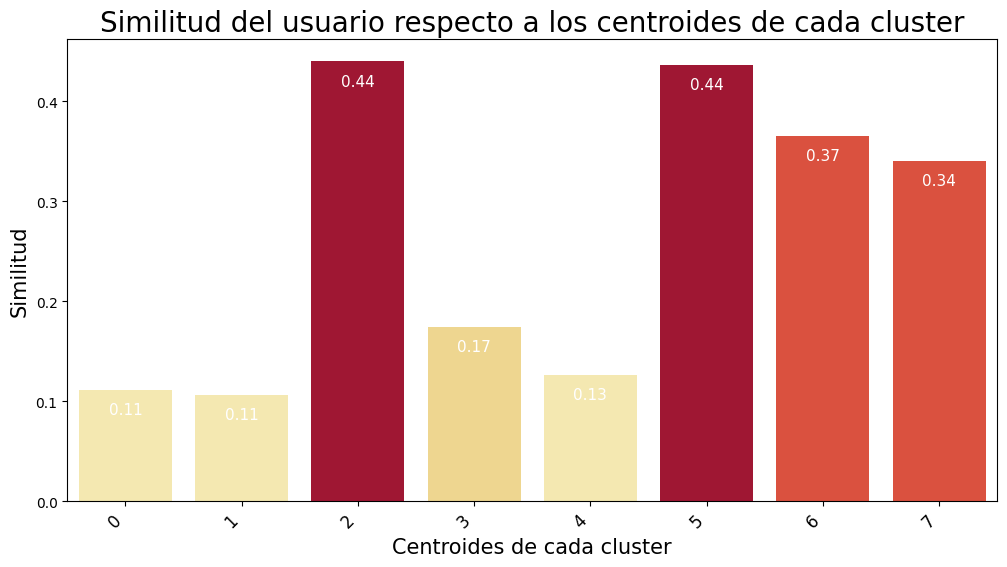

In [ ]:
# Crear una matriz de similitud
n = len(centroides_df)  # Número de filas en centroides_df
vector_similitud_usuario = np.zeros((1, n))  # Crear una matriz de similitud de tamaño 1 x n

# Calcular la similitud entre la nueva entrada y cada fila en centroides_df
for i in range(n):
    vector_similitud_usuario[0, i] = similitud_usuarios(centroides_df.iloc[i], nueva_entrada.iloc[0])

print(vector_similitud_usuario)
# Crear un gráfico de barras en lugar de un heatmap para mejorar la visualización
plt.figure(figsize=(12, 6))

# Generar un gráfico de barras
centroides_df = centroides_df.reset_index(drop=True)
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)
bars = sns.barplot(x=centroides_df.index, y=vector_similitud_usuario.flatten(), palette=colors_from_values(vector_similitud_usuario.flatten(), "YlOrRd"))

# Anotar los valores exactos en cada barra
for bar, value in zip(bars.patches, vector_similitud_usuario.flatten()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{value:.2f}', ha='center', va='center', color='white', fontsize=11)

# Personalizar títulos y etiquetas
plt.title('Similitud del usuario respecto a los centroides de cada cluster', fontsize=20)
plt.xlabel('Centroides de cada cluster', fontsize=15)
plt.ylabel('Similitud', fontsize=15)

# Ajustar rotación y alineación de las etiquetas en el eje X
plt.xticks(rotation=45, ha='right', fontsize=12)

# Mostrar el gráfico
plt.show()

Obtenemos el identificador de los 2 clusters más similares

In [ ]:
# Seleccionar los dos mejores clusters
clusters_seleccionados = np.argsort(vector_similitud_usuario) # Ordenamos los clusters según los valores de similitud
clusters_seleccionados = clusters_seleccionados.flatten()[-2:][::-1]  # Seleccionamos los dos más similares

# Se toman los problemas pertenecientes a los dos clusters seleccionados
problemas_seleccionados = problemas_df[problemas_df['Cluster'].isin(clusters_seleccionados)]

## Seleccionar los problemas

Obtenemos los problemas de los clusters seleccionados y los filtramos de acuerdo a las preferencias del usuario activo

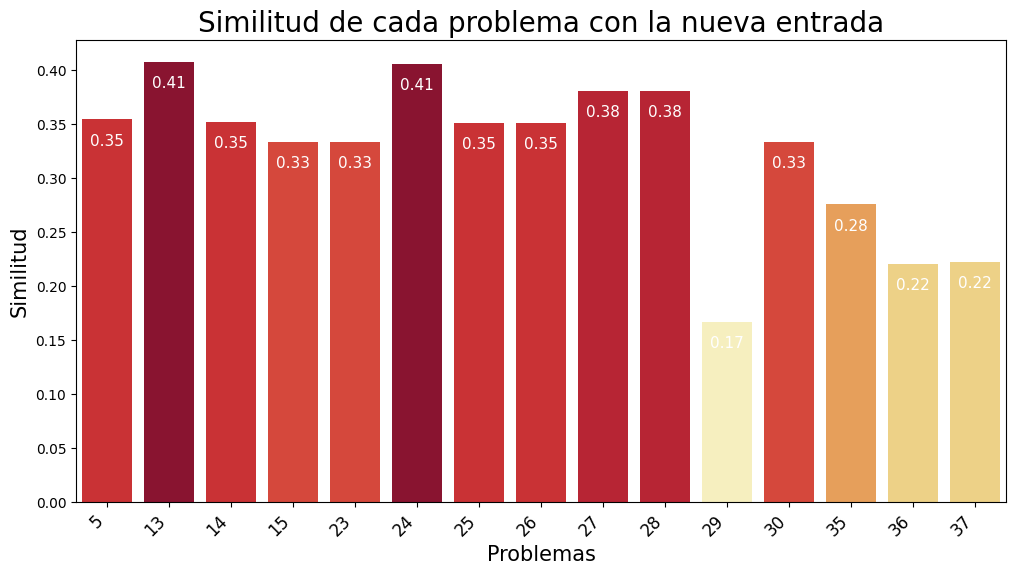

In [ ]:
# Crear una matriz de similitud para almacenar la similitud entre cada problema y la nueva entrada
n = len(problemas_seleccionados)  # Número de problemas seleccionados
vector_similitud_problemas = np.zeros((n, 1))  # Crear una matriz de tamaño n x 1

# Calcular la similitud entre la nueva entrada y cada problema en problemas_seleccionados
for i in range(n):
    vector_similitud_problemas[i, 0] = similitud_problemas(problemas_seleccionados.iloc[i], nueva_entrada.iloc[0])

# Crear un gráfico de barras en lugar de un heatmap para mejorar la visualización
plt.figure(figsize=(12, 6))

# Generar un gráfico de barras
bars = sns.barplot(x=problemas_seleccionados.index, y=vector_similitud_problemas.flatten(), palette=colors_from_values(vector_similitud_problemas.flatten(), "YlOrRd"))

# Anotar los valores exactos en cada barra
for bar, value in zip(bars.patches, vector_similitud_problemas.flatten()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{value:.2f}', ha='center', va='center', color='white', fontsize=11)

# Personalizar títulos y etiquetas
plt.title('Similitud de cada problema con la nueva entrada', fontsize=20)
plt.xlabel('Problemas', fontsize=15)
plt.ylabel('Similitud', fontsize=15)

# Ajustar rotación y alineación de las etiquetas en el eje X
plt.xticks(rotation=45, ha='right', fontsize=12)

# Mostrar el gráfico
plt.show()

Mostrar los problemas más similares a lo que busca el usuario activo

In [ ]:
# Obtener los índices de los problemas ordenados de mayor a menor similitud
mejores_indices = np.argsort(vector_similitud_problemas[:, 0])[::-1]

# Ordenar el DataFrame problemas_seleccionados usando esos índices
problemas_ordenados = problemas_seleccionados.iloc[mejores_indices]

problemas_ordenados = problemas_ordenados.drop(columns=['Cluster', 'Conocimientos previos para resolver el problema.', '¿Cuáles son los conocimientos fundamentales tanto de trigonometría como de otras áreas que se necesitan para resolver el problema que propuso? ', 'Año escolar o edad de los estudiantes donde ha propuesto o propone ese problema.'])
# Título personalizado con diseño
titulo_html = """
<div style="text-align: center; padding: 20px; background-color: #333; color: white; border-radius: 10px; font-family: 'Arial';">
    <h2 style="margin: 0;">Problemas recomendados</h2>
</div>
"""

# Mostrar el título estilizado
display(HTML(titulo_html))

# Usar pandas Styler para aplicar estilo a la tabla
problemas_ordenados_styled = (
    problemas_ordenados.style
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '18pt'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', 'transparent'), ('font-family', 'Arial'), ('font-size', '12pt'), ('text-align', 'center'), ('color', 'white')]},
        {'selector': 'td', 'props': [('font-family', 'Arial'), ('font-size', '11pt'), ('text-align', 'center'), ('border', '1px solid #555'), ('background-color', '#333'), ('color', 'white')]},
    ])
    .background_gradient(cmap='coolwarm', axis=None)  # Gradiente de color para la tabla sin distinción de filas o columnas
    .set_properties(**{'border': '1px solid #555', 'border-radius': '5px'})  # Bordes con color oscuro y redondeados
)

# Mostrar la tabla estilizada
display(problemas_ordenados_styled)

problemas_ordenados.to_excel('output.xlsx', index=False)

,Texto del enunciado del problema: redacte aquí el enunciado del problema.,"Si el enunciado del problema está acompañado de una imagen, por favor, cárguela aquí (opcional).",Solución del problema (opcional): cargue aquí la resolución del problema.,"Indique la fuente de referencia o de la cuál se inspiró para proponer el problema (libro, paper, Internet, etc)."
13,Un octágono regular tiene lado de 12 metros. Encuentra la diferencia de área entre las circunferencias inscrita y circunscrita al mismo,nan,nan,Matemática Polimodal: Análisis 1. Longseller
24,Hallar A y B en los siguientes triángulos rectángulos.,https://drive.google.com/open?id=1MtbyKHlHRd9iKAnlbiCqNadIyPw8l-r3,nan,Si
28,"Resolver las siguientes situaciones problemáticas utilizando el teorema de Pitágoras, del seno y/o del coseno.",https://drive.google.com/open?id=1fP_ZXJMXk_T2_Bin7gAXEwOuM2uVvm5v,nan,Matemática 1 Activa. Editorial Puerto de Palos.
27,https://drive.google.com/open?id=1wEVXpAovvdbRjmduNrzkb0Ov03PaYmAn,https://drive.google.com/open?id=17cTkSD4_qAD-aKNbxFohURYLonwx5JcS,Matemática 1 Activa. Editorial Puerto de Palos.,Si
5,"Se tiende un alambre de 23m desde, desde la parte más alta de la copa de un arbol, el cual forma un ángulo de 35 grados con la superficie que es totalmente horizontal. Cual es la altura del árbol?",https://drive.google.com/open?id=1kjYeEdb8hvYQLKwkev9zp2MRJf_-LvC2,https://drive.google.com/open?id=1AMfw2jwN__kzvPhFmQVyx4rVCjjQSbaD,Internet
14,Hallar la altura de un triángulo isósceles si el lado desigual mide 40 cm y su ángulo opuesto tiene una amplitud de 30°.,nan,nan,nan
26,"Dados los siguientes triángulos, hallar los datos desconocidos utilizando el teorema del coseno.",nan,Matemática 1 Activa. Editorial Puerto de Palos.,Si
25,"Dados los siguientes triángulos, hallar los datos desconocidos utilizando el teorema del seno.",https://drive.google.com/open?id=1LSvm6AnMPQjhET5eqngjmL65JsnX-_JR,Matemática 1 Activa. Editorial Puerto de Palos.,Si
15,"Una persona observa una torre con un ángulo de elevación de 32°. Si avanza 40 metros en dirección a la torre, la observa con un ángulo de 70°. a) Calcula la altura de la torre si la estatura de la persona es de 1,65 metros. b) ¿A qué distancia de la torre estaba inicialmente?",nan,nan,No
30,Escrito,nan,nan,Internet
